## Chapter 12: Introduction to nonlinear learning

# 12.6 Validation error

In the previous Section we introduced three fundamental families of *universal approximators* referred to as kernels, neural networks, and trees.  There we also saw how our pursuit for the appropriate nonlinearity in a dataset is best organized by employing a `model` of the general form

\begin{equation}
\text{model}\left(\mathbf{x},\mathbf{w}\right) =   w_0 + f_1\left(\mathbf{x}\right){w}_{1} +  f_2\left(\mathbf{x}\right){w}_{2} + \cdots + f_B\left(\mathbf{x}\right)w_B.
\end{equation}

where the $B$ units $f_1,...,f_B$ all come *only* one of these three families.  The *capacity* - or nonlinear potential - of any given `model` is then controlled by a combination of the kind of units we use (some have more capacity than others - like e.g., a neural network compared to a polynomial unit) and the number of units $B$ we use.

In the previous Section we also saw how *training error* - or the error of a `model` measured on the data used to train it - is an improrer measurement tool for detemrining the proper capacity (or nonlinearity) of a `model` with real data.  In this Section we introduce our first proper measurement tool for determining proper `model` capacity: *validation error*.

**Note:** for the sake of simplicity in the examples of this Section we use `polynomial` universal approximators, but in each example described here we can just as easily use any other.

In [ ]:
## This code cell will not be shown in the HTML version of this notebook
# imports from custom library
import sys
sys.path.append('../../')
from mlrefined_libraries import math_optimization_library as optlib
from mlrefined_libraries import nonlinear_superlearn_library as nonlib

# demos for this notebook
regress_plotter = nonlib.nonlinear_regression_demos_multiple_panels
classif_plotter = nonlib.nonlinear_classification_visualizer_multiple_panels
static_plotter = optlib.static_plotter.Visualizer()
basic_runner = nonlib.basic_runner
classif_plotter_crossval = nonlib.crossval_classification_visualizer
datapath = '../../mlrefined_datasets/nonlinear_superlearn_datasets/'

# import autograd functionality to bulid function's properly for optimizers
import autograd.numpy as np

# import timer
from datetime import datetime 
import copy
import math

# this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

## 12.6.1 A general diagnosis of underfitting / overfitting

There is no simple closed form mathematical way of determining the proper `model` for a generic supervised / unsupervised learning dataset - in general we will need to try out a range of `models` in order to find the one with the most appropriate amount of capacity for a given dataset.  This makes quantifying what makes a `model` "good" for a given dataset a somewhat challenging task at first glance.  It is easier to answer this quandary by tackling its negative: what makes a `model` "bad" for a given dataset?  

Well we know if a `model` has *too little* capacity it *underfits* a dataset, meaning that it is too rigid to accurately represent the sort of nonlinearity present in the phenomenon underlying the data.  Conversely if a `model` has *too much* capacity it *overfits* the data, being too flexible to adequately match the nonlinearity present.  When we as humans visualize a dataset, and a `model` fit to it, we can *see* how well the `model` is performing, and so can visually determine if more or less capacity is required.  But we of course cannot / do not want to rely on our visualization skills in general, not only because we cannot visualize most datasets (given that they are too high dimensional), but because our ultimate aim is to automate the process of tuning the capacity of a `model` correctly.  So how can we codify our abiilty to diagnose what makes a `model` "bad"?

By examining a few simple examples - like the regression one below - we can work out an idea of what to do.

<IPython.core.display.Javascript object>


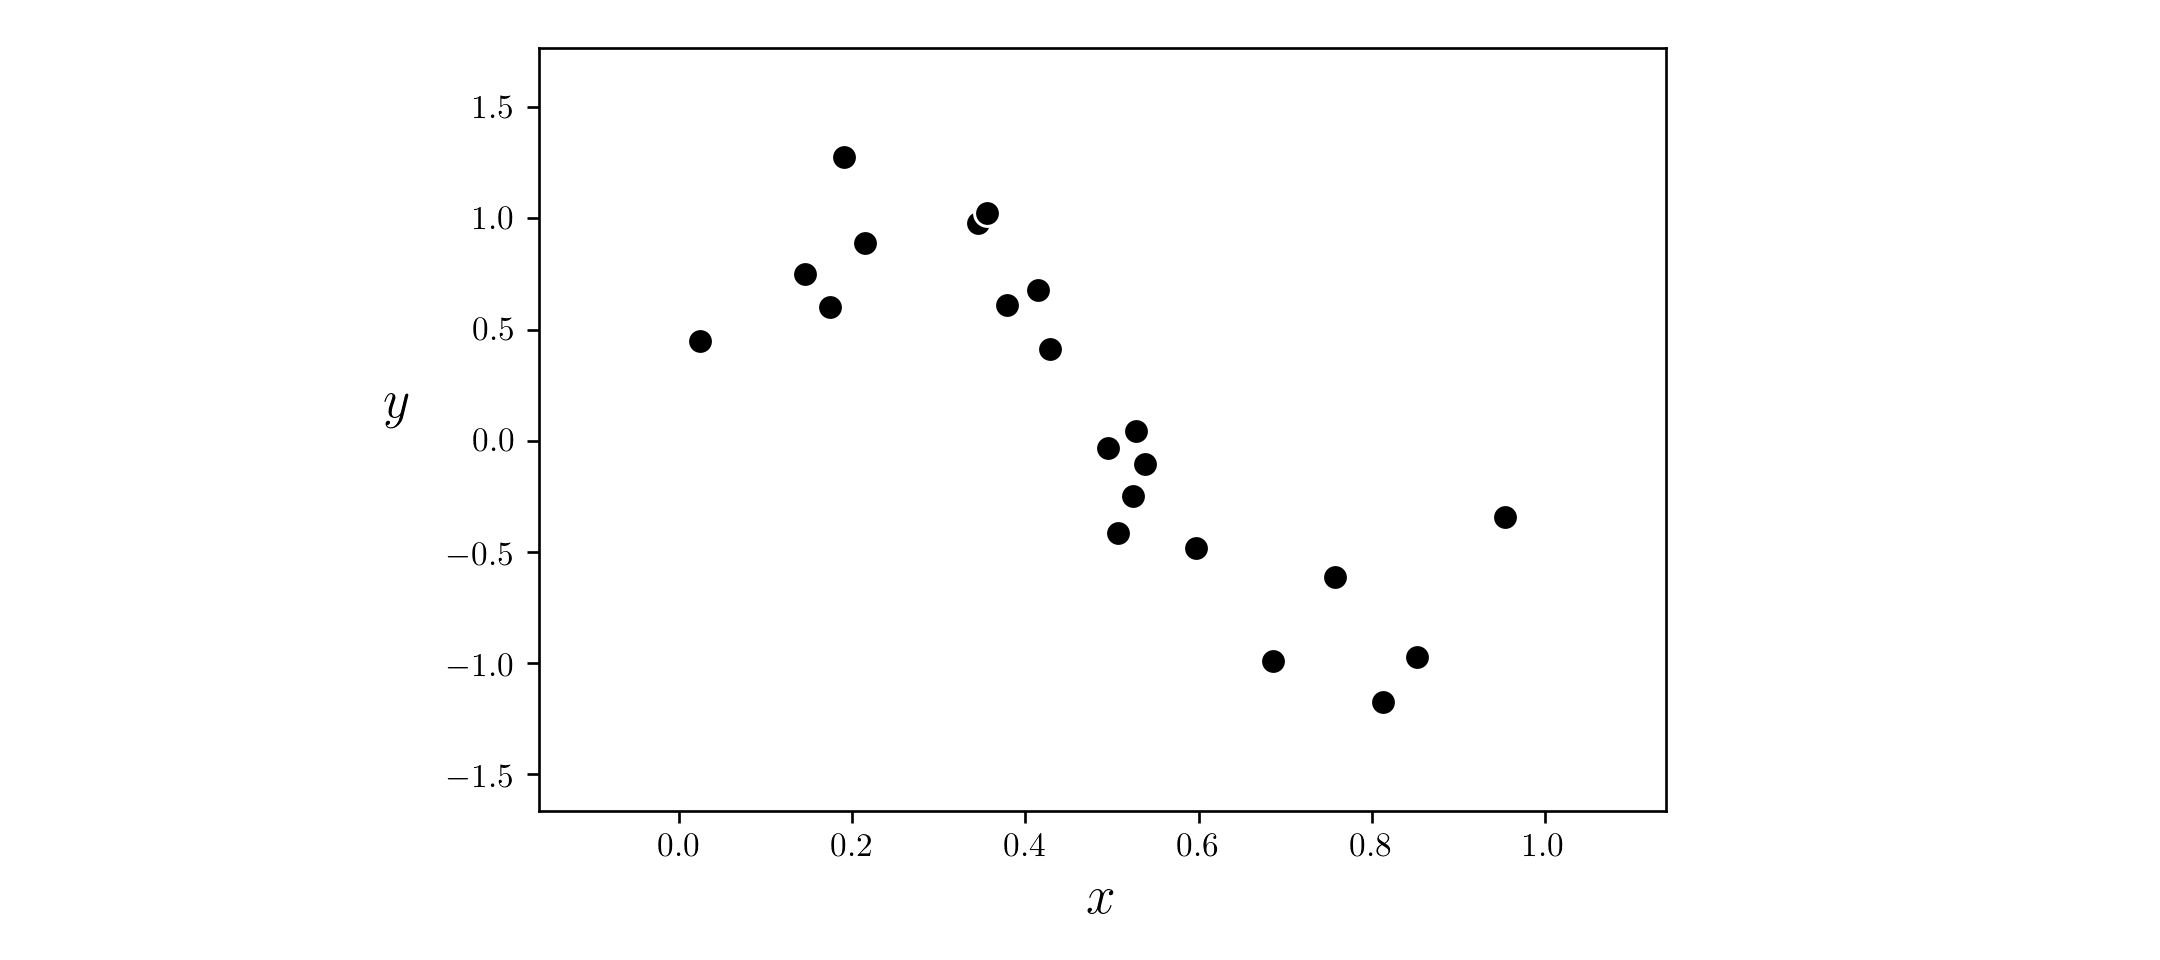

In [24]:
## This code cell will not be shown in the HTML version of this notebook
# load in dataset
csvname = datapath + 'noisy_sin_sample.csv'
data = np.loadtxt(csvname,delimiter = ',')
x = data[:-1,:]
y = data[-1:,:] 

# show data
demo1 = regress_plotter.Visualizer(data)
demo1.plot_data()

Below we show three `model` fits to the above data.  In the left panel we show a linear `model` - which we can see *underfits* the data, in the middle panel we show a degree $19$ polynomial `model` - which cleary *overfits* the data present, and in the right panel we show a degree $3$ polynomial `model` - which appears to fit quite well.  From studying the left two panels we can ask ourselves: what do both the underfitting and overfitting patterns have in common, that the "good" `model` does not?

<IPython.core.display.Javascript object>


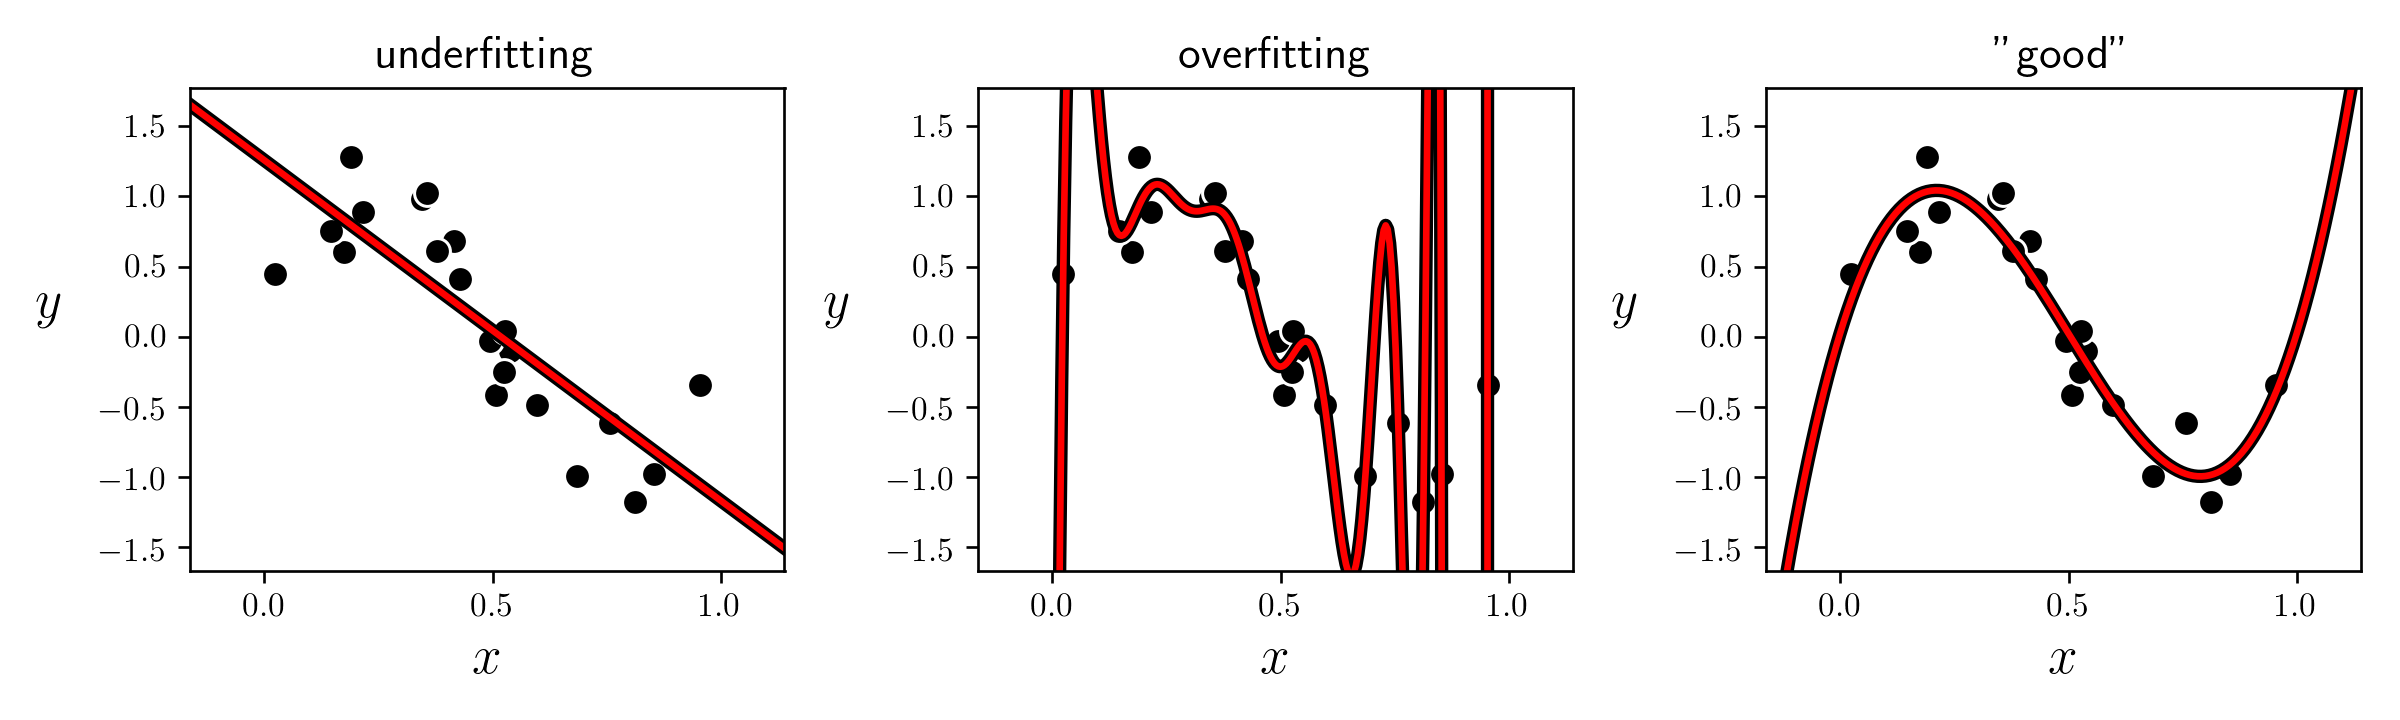

In [34]:
## This code cell will not be shown in the HTML version of this notebook
### underfitting model ###
# import the v1 library
mylib1 = nonlib.library_v1.superlearn_setup.Setup(x,y)

# choose features
mylib1.choose_features(name = 'polys',degree = 1)

# choose normalizer
mylib1.choose_normalizer(name = 'none')

# choose cost
mylib1.choose_cost(name = 'least_squares')

# fit an optimization
mylib1.fit(max_its = 1,optimizer = 'newtons method')

#### overfitting model ####
# import the v1 library
mylib2 = nonlib.library_v1.superlearn_setup.Setup(x,y)

# choose features
mylib2.choose_features(name = 'polys',degree = 30)

# choose normalizer
mylib2.choose_normalizer(name = 'none')

# choose cost
mylib2.choose_cost(name = 'least_squares')

# fit an optimization
mylib2.fit(max_its = 1,optimizer = 'newtons method',epsilon =0 )# 10**(-17))

#### just right model ####
# import the v1 library
mylib3 = nonlib.library_v1.superlearn_setup.Setup(x,y)

# choose features
mylib3.choose_features(name = 'polys',degree = 3)

# choose normalizer
mylib3.choose_normalizer(name = 'none')

# choose cost
mylib3.choose_cost(name = 'least_squares')

# fit an optimization
mylib3.fit(max_its = 1,optimizer = 'newtons method',epsilon = 10**(-17))

# plot resulting fits
demo1.plot_three_fits(mylib1,mylib2,mylib3)

One thing that clearly differentiates the underfitting and overfitting `models`: the former does a poor job of representing the data *we already have*, while the latter represents this data very well (indeed too well).  Scanning the left two panels would you agree that one common problem with both the underfitting/overfitting `models` is that - while they differ in how well they represent data *we already have* - they will both fail to adequately represent *new data*, generated via the same process by which the current data was made?  The data we have clearly follows some sort of wavy sinusoidal pattern - one that is well represented by the `model` on the right - so if any future data generated by the same process looks at all similar to this neither our underfitting or overfitting `models` will represent it appropriately.  Another way of thinking about it: we learn regressors to make predictions - so that we can appropriately predict the output for a new input point $x_{\text{new}}$.  Given the data we already have, would we trust either of the underfitting / overfitting `model`s to perform this task well?  Certainly not.  On the other hand - the "good" model seems like it would work well as a predictor for future datapoints.  

The same sort of intuition holds regardless of the learning task at play.  For example, below is a relatively simple two class nonlinear classification dataset.

<IPython.core.display.Javascript object>


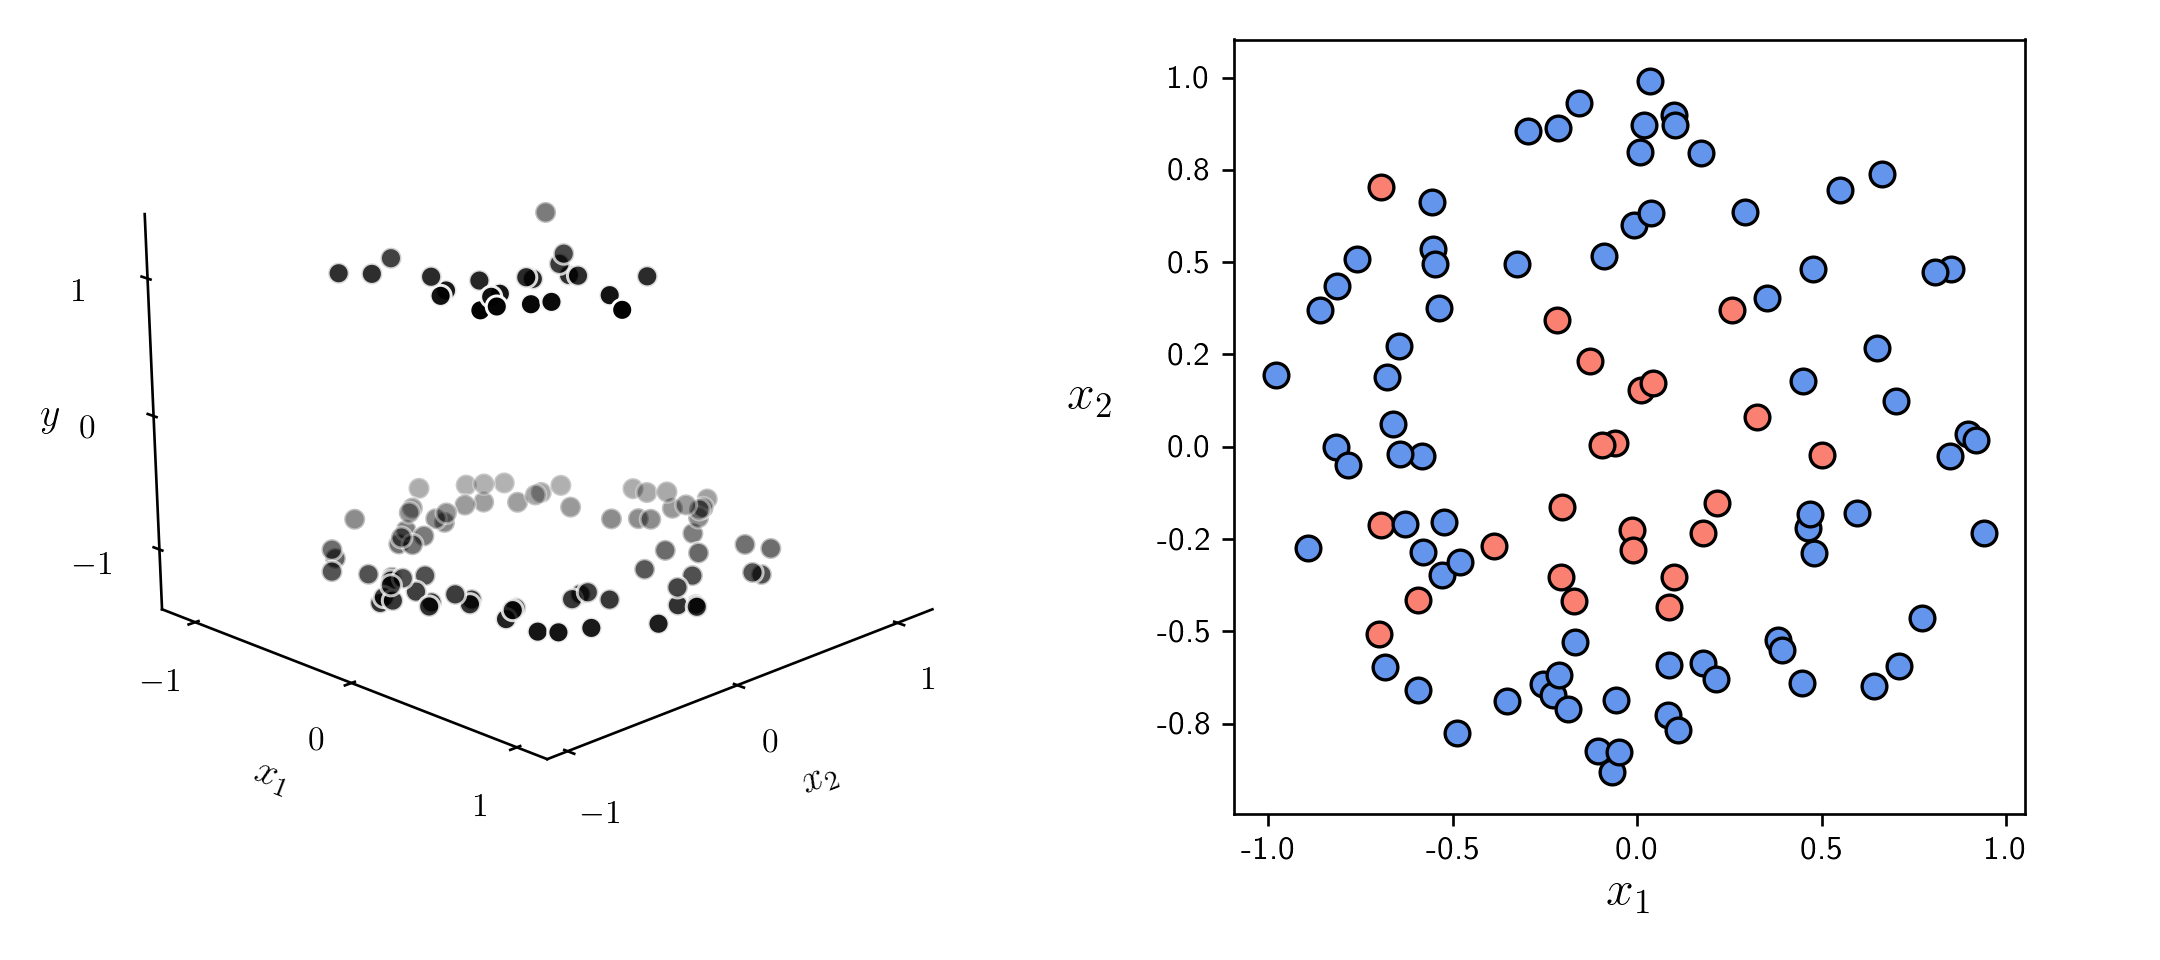

In [17]:
## This code cell will not be shown in the HTML version of this notebook
# load in dataset
csvname = datapath + 'new_circle_data.csv'

data = np.loadtxt(csvname,delimiter = ',')
x = data[:-1,:]
y = data[-1:,:] 

demo2 = classif_plotter.Visualizer(csvname)
demo2.plot_data();

Now we perform the same sort of experiment - we examine an underifitting (left panel), overfitting (middle panel), and 'just right' (right panel) `model` below.  These were created using a linear, degree 15 polynomial, and degree 2 polynomial `model` respectively.  Notice here that the underfitting linear model just classifies everything as part of the blue class.  Again we can ask ourselves: studying the left two panels what do both the underfitting and overfitting patterns have in common, that the 'just right' `model` does not?

<IPython.core.display.Javascript object>


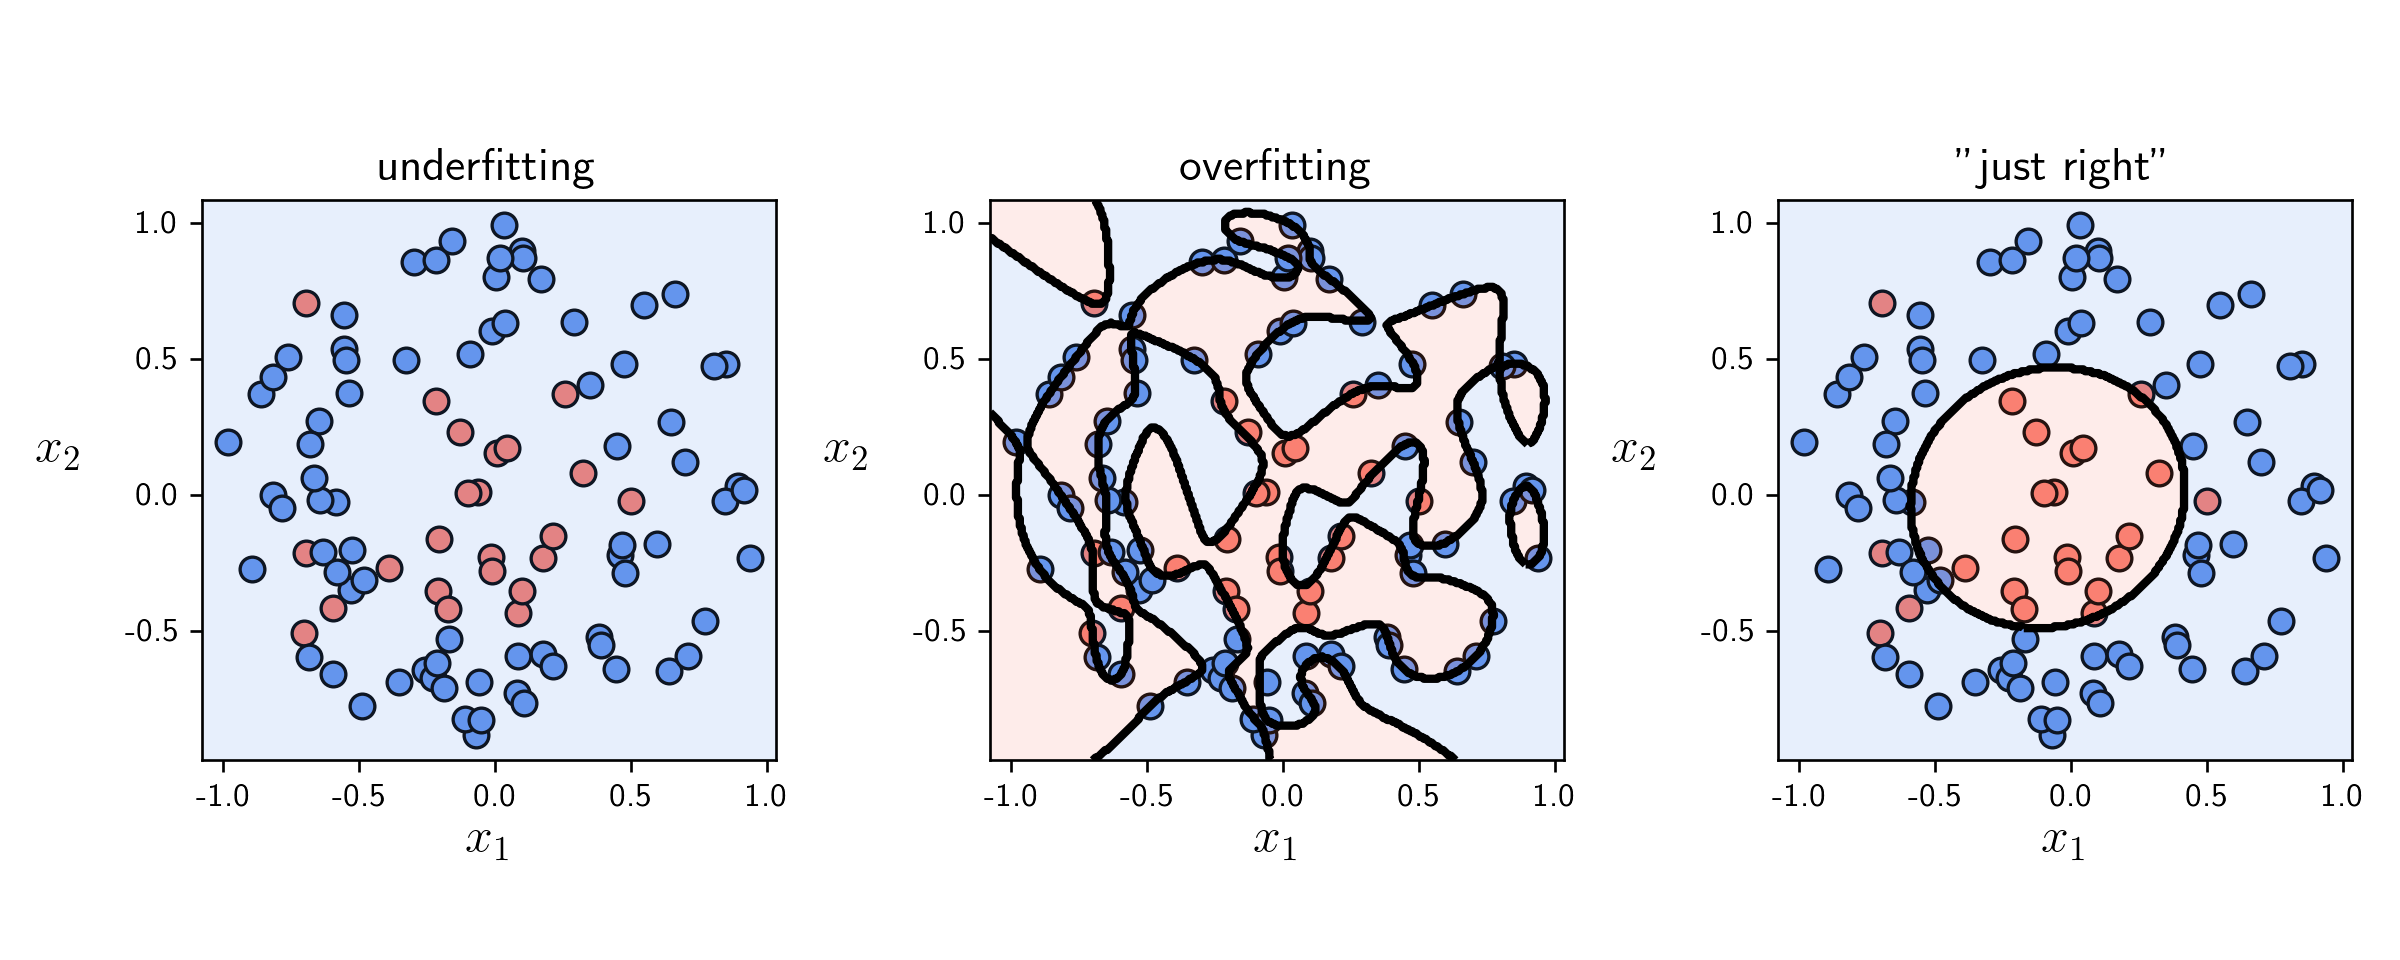

In [19]:
## This code cell will not be shown in the HTML version of this notebook
### underfitting model ###
# import the v1 library
mylib4 = nonlib.library_v1.superlearn_setup.Setup(x,y)

# choose features
mylib4.choose_features(name = 'polys',degree = 1)

# choose normalizer
mylib4.choose_normalizer(name = 'none')

# choose cost
mylib4.choose_cost(name = 'softmax')

# fit an optimization
mylib4.fit(max_its = 10,optimizer = 'newtons method')

#### overfitting model ####
# import the v1 library
mylib5 = nonlib.library_v1.superlearn_setup.Setup(x,y)

# choose features
mylib5.choose_features(name = 'polys',degree = 15)

# choose normalizer
mylib5.choose_normalizer(name = 'none')

# choose cost
mylib5.choose_cost(name = 'softmax')

# fit an optimization
mylib5.fit(max_its = 10,optimizer = 'newtons method',epsilon = 10**(-17))

#### just right model ####
# import the v1 library
mylib6 = nonlib.library_v1.superlearn_setup.Setup(x,y)

# choose features
mylib6.choose_features(name = 'polys',degree = 2)

# choose normalizer
mylib6.choose_normalizer(name = 'none')

# choose cost
mylib6.choose_cost(name = 'softmax')

# fit an optimization
mylib6.fit(max_its = 10,optimizer = 'newtons method',epsilon = 10**(-17))

# plot resulting fits
demo2.plot_three_fits(mylib4,mylib5,mylib6)

Again we could say that clearly the underfitting `model` fails to represent data we *already have*, while the overfitting `model` fits our current data very well (all of the points are indeed classified correctly).  Once again however both the underfitting/overfitting `models` both will fail to adequately represent *new data*, generated via the same process by which the current data was made.   The data we have is largely separated by a circular boundary  - one like the one found by the `model` on the right - so if any future data generated by the same process looks similar, neither our underfitting nor overfitting models will appropriately represent it.

Moving beyond the visualizations, what kind empirical quantity can we use to make this distinction between "good" and "bad" (underfitting / overfitting `models`)?  What empircal measurement do we even have to quantify how well a `model` fits a given dataset?   Well - up to this point - we have almost universally employed just one kind of measurement: the *cost function value evaluated over the entire set of training data*, or *training errror*.  This we have largely used as a way of determining now well we have tuned a `model`'s parameters / minimized an associated cost function.  It does not tell us how "good" a particular `model` is, only how well a `model` can be made to fit a particular set of *training data*.  

So - in other words - the value of our cost function on the training data (or the *training error*) does not tell us when a `model` has the right capacity (has optimally set parameters) - we need another way of measuring the 'goodness' of a `model`.

> The value of our cost function on the training data  - also known as the *training error* - does not tell us when a `model` has a proper capacity - we need another way of measuring the 'goodness' of a `model`.

## 12.6.2  Measuring validation error 

We now have a general diagnosis for the problem of underfitting / overfitting, that such a `model` does not accurately represent new data we might receive in the future.  But how can we make use of this description - we of course do not have access to any "new data we will receive in the future" so how are we to know if a `model` works well for a given dataset? 

The first practical solution - and the one employed universally in machine learning / deep learning - is to simply remove a *random* portion of the data we have from training and pretend that it is 'new data we might receive in the future'.  In other words we cut out a random chunk of the dataset we have, train our selection of `models` on only the data that remains, and *validate* the performance of each `model` on this randomly removed chunk of 'new' data.  The portion of our data that remains for use to train our `models` is referred to as the *training set*, with the portion used to *validate* the effecacy of each `model` referred to as the *validation set*.   So in other words, we determine the best choice from a selection of `models` by choosing the one with the lowest validation error.    

> We use a `model`s error on a *validation set* - referred to as its *validation error* - to determine how well a `model`'s capacity has been set with respect to a given dataset.  From a set of `models` to try out we then choose the one that provides the lowest *varlidation error*.  

Validation error - unlike training error - is in fact a proper measurement tool for determining the quality of a `model`.

This idea of splitting up the data into training and validation sets is illustrated figuratively below.


<figure>
  <img src= '../../mlrefined_images/nonlinear_superlearn_images/Fig_5_15.png' width="60%" height="auto" alt=""/>
  <figcaption>   
<strong>Figure 4:</strong> <em> Splitting the data into testing and validation sets.  The original data (left panel) shown here as the entire circular mass is split randomly (middle panel) into $k$ non-overlapping sets (here $k=3$). (right panel) One piece, or $\frac{1}{k}$ of the original dataset, is then taken randomly as the testing set with the remaining pieces, or $\frac{k-1}{k}$ of the original data, taken as the training set. </em>  </figcaption> 
</figure>

At this point there are still many questions to address - e.g., how much of our dataset do we set aside as validation?  which `models` should we try out? - but before addressing these lets examine two simple examples below to get a better intuition as to why *validation error* helps determine the best `model` from a given set of choices.

In [ ]:
## This code cell will not be shown in the HTML version of this notebook
#### split data into training and testing sets ####
def make_train_test_split(x,y,train_portion):
    # translate desired training portion into exact indecies
    r = np.random.permutation(x.shape[1])
    train_num = int(np.round(train_portion*len(r)))
    train_inds = r[:train_num]
    test_inds = r[train_num:]

    # define training and testing sets
    x_train = x[:,train_inds]
    x_test = x[:,test_inds]

    y_train = y[:,train_inds]
    y_test = y[:,test_inds]
    
    return x_train,y_train,x_test,y_test

#### <span style="color:#a50e3e;">Example 3. </span>  A simple regression cross validation example

In this example we illustrate the use of the training / validation data split detailed above on the $N=1$ dimensional input sinusoidal regression dataset used previously in Example 1.  Here we use $\frac{2}{3}$ of the original set of $21$ data points for training, and the other $\frac{1}{3}$ for validation.  The set of `models` we compare here are polynomials of degree $D = 1,...,10$.  Moving the slider from left to right below shows the fit of each polynomial `model` from degree $1$ to $10$ sequentially on the original dataset (upper left panel), training data (top right panel), and validation data (bottom left panel).  The errors on both the training (shown in blue) and validation (shown in yellow) data is shown in the bottom right panel.  Since we are testing a sequence of models where each subsequent polynomial includes only one more unit than the previous, the horizontal axes of this errors panel displays the `number of units` 

Pulling the slider from left to right, notice that then the validation error is at its *lowest* - that is, the error on our set of data we are pretending to receive in the future - that indeed the `model` providing this measurement is indeed a good fit to the entire dataset.  Here that `model` is a degree $3$ polynoimal.  Of course as we use more and more polynomial units - mmoving the slider from left to right - the fit to the training data continues to decrease since the higher degree `models` will indeed fit it better and better.  However as the training error continues to decrease, the corresponding validation error starts climbing rapidly as the corresponding `models` become a poorer and poorer representation of the validation data (notice after a certain point the validation error *goes off the screen* its so large).


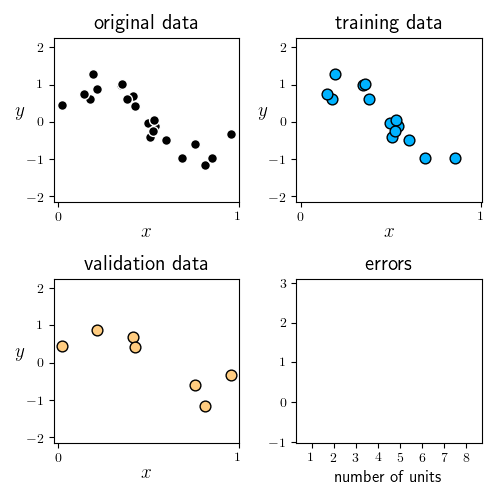
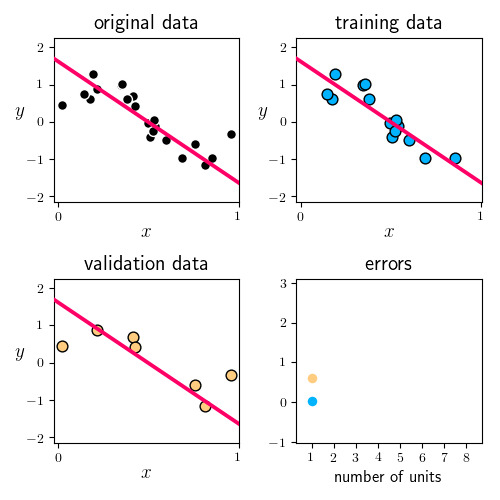
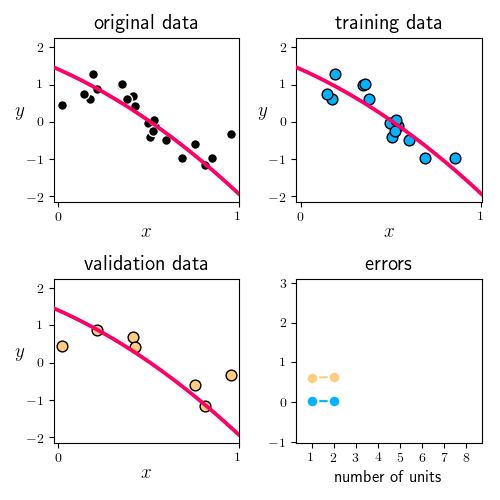
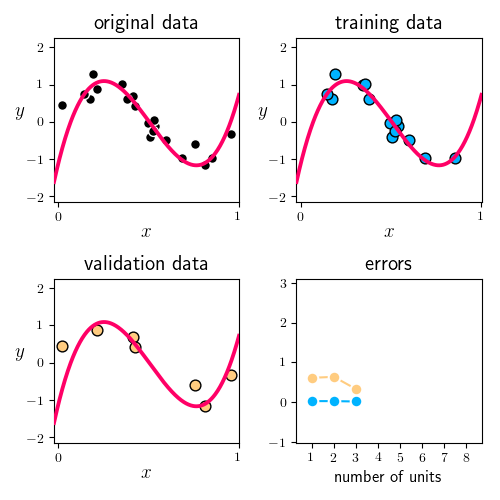
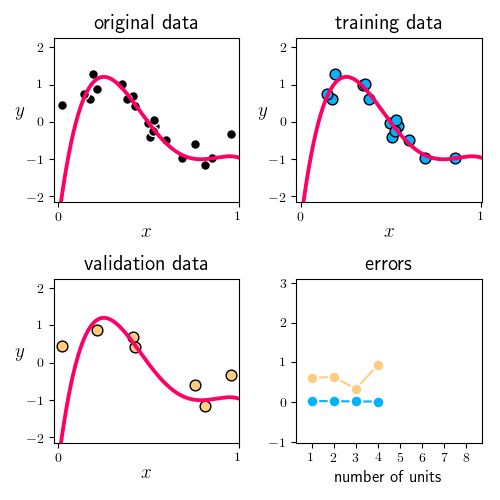
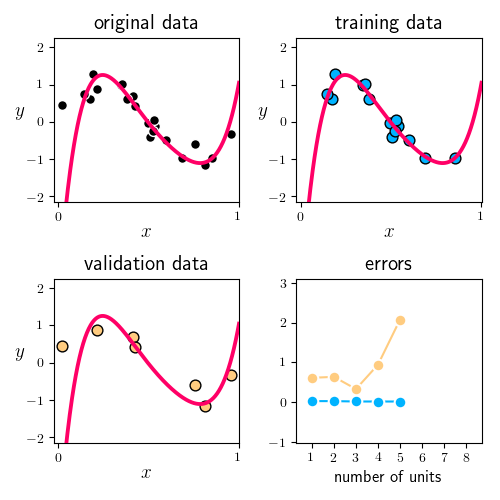
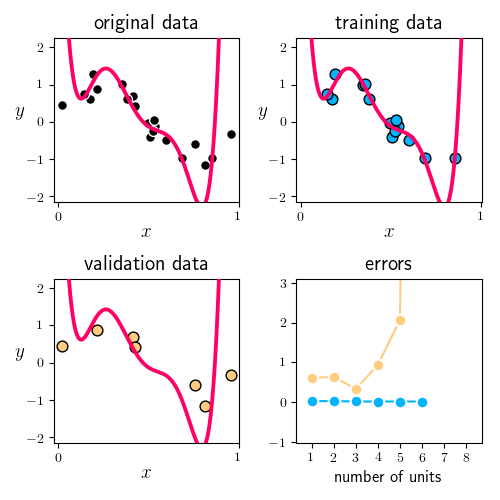
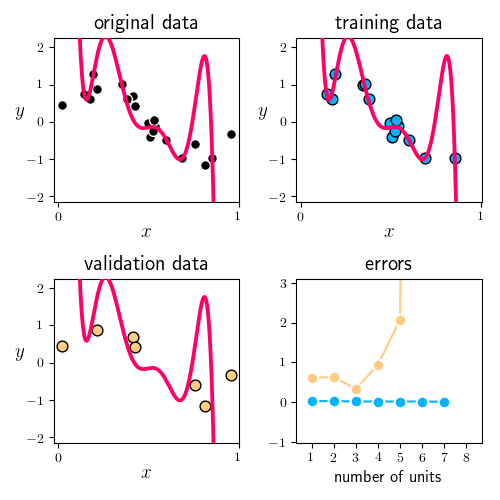
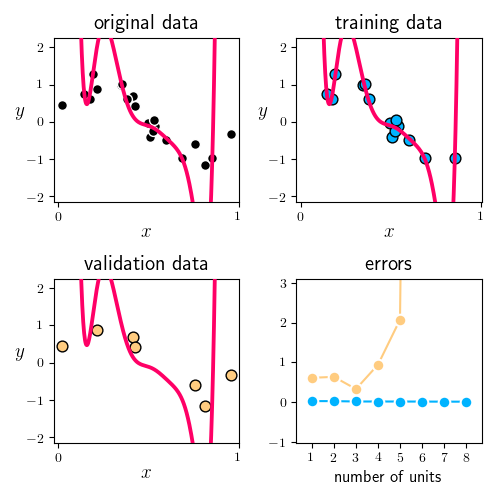

In [98]:
## This code cell will not be shown in the HTML version of this notebook
demo3 = nonlib.regression_basis_single.Visualizer()
csvname = datapath + 'noisy_sin_sample.csv'
demo3.load_data(csvname)
demo3.brows_single_cross_val(basis='poly',num_elements = [v for v in range(1,9)],folds = 3)

#### <span style="color:#a50e3e;">Example 4. </span>  A simple classification cross validation example

In this example we illustrate the use of the training / validation data split detailed above for the classification dataset shown in Example 2.  Here we use $\frac{2}{3}$ of the original set of $99$ data points for training, and the other $\frac{1}{3}$ for validation.  

The set of `models` we compare here are polynomials of degree $D = 1,...,7$.  Note because the input here $N=2$ dimensional and we are using full degree polynomial `models`, the number of units in each successive model increases by more than $1$ unit at a time.  Indeed one can compute that a full degree $D$ polynomial - which in this instance consists of all units of the form 

\begin{equation}
f\left(\mathbf{x}\right) = x_1^ix_2^j
\end{equation}

for $i + j \leq D$ - consists of $\binom{2+D}{D} - 1$ such units.

Once again we animate the complete fit of each `model` to the training data, showing each complete fit and the original data (in the top left panel), and the training data (top right panel), and the validation data (bottom left panel).  The training and validation error is likewise shown in the bottom right panel.  Notice as you pull the slider from left to right the resulting fit and errors of each subsequent model are shown sequentially from degree $D = 1$ to degree $D = 7$.

Once again, notice how the `model` that provides the smallest validation error - here the degree $D = 2$ polynomial - provides the best nonlinear decision boundary for the entire dataset.  As the training error continues to decrease we *overfit* it, with such `models` providing a poor solution for the validation data.


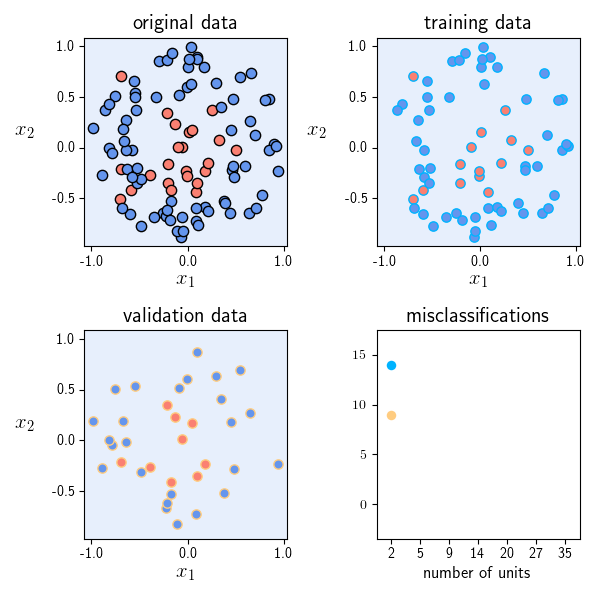
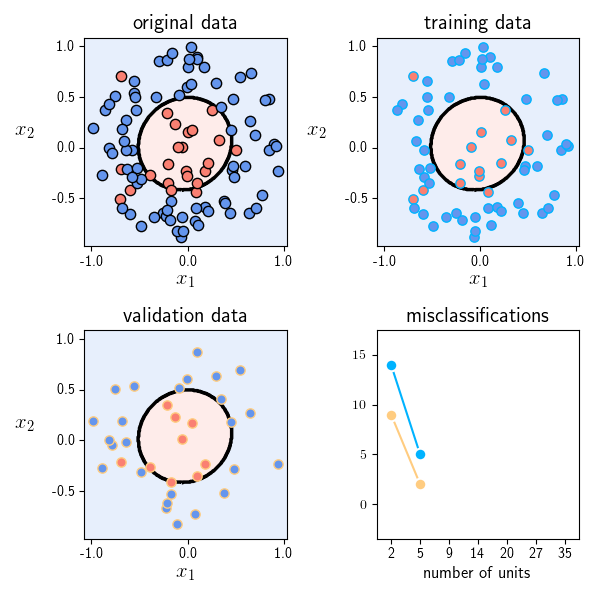
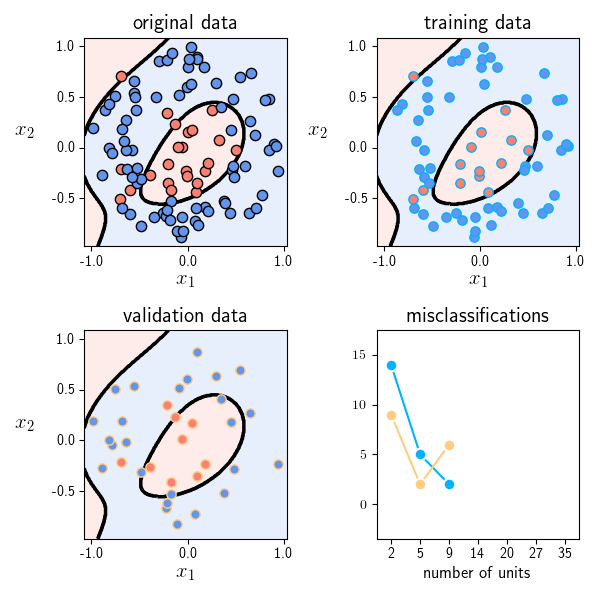
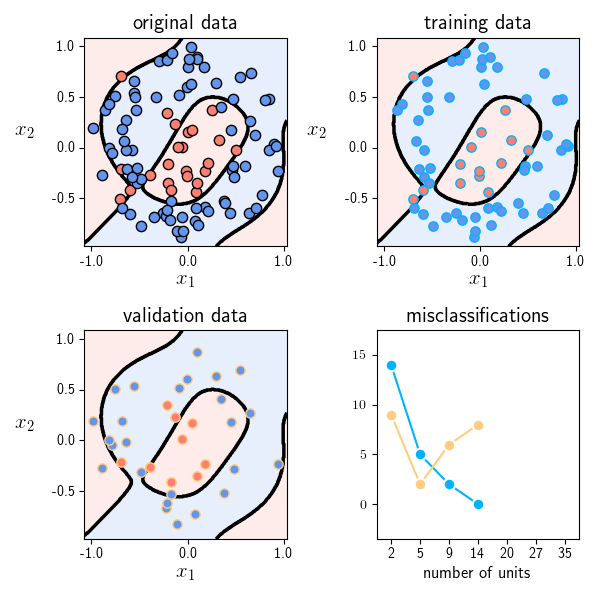
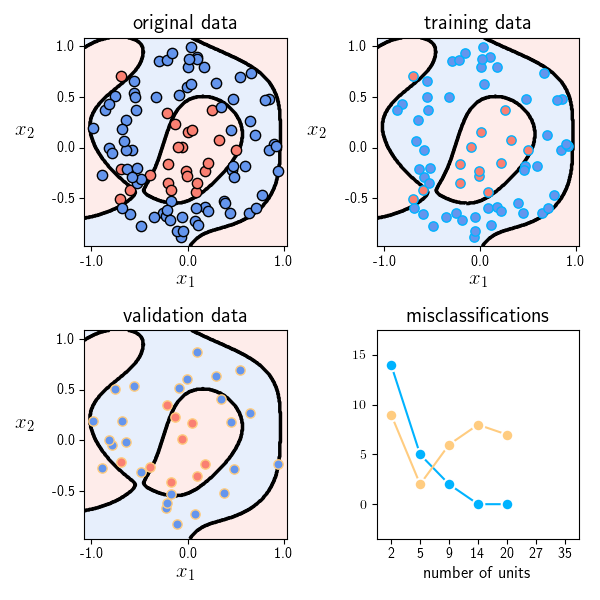
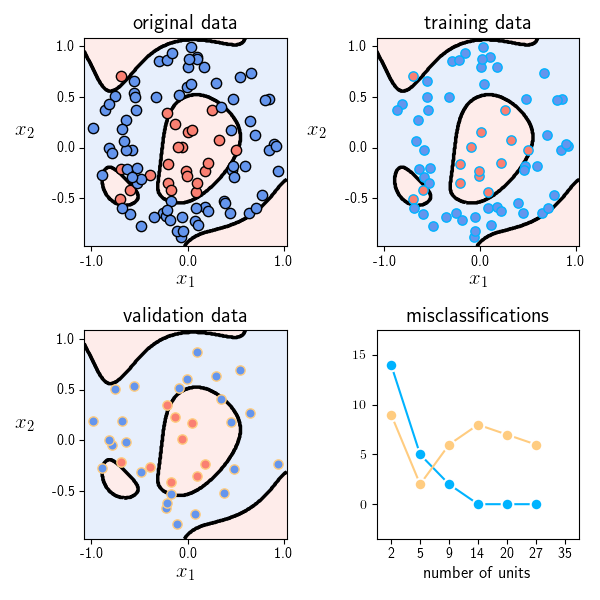
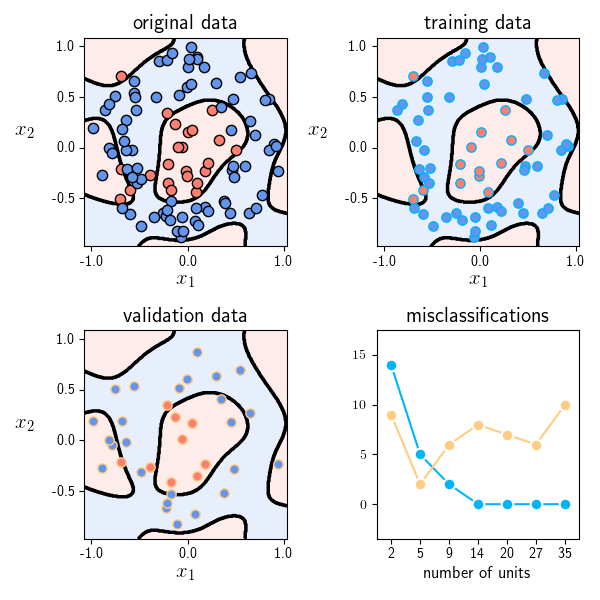

In [126]:
## This code cell will not be shown in the HTML version of this notebook
# load in dataset
csvname = datapath + 'new_circle_data.csv'
data = np.loadtxt(csvname,delimiter = ',')
x = data[:-1,:]
y = data[-1:,:] 

### run cross validation experiments ###
degrees = np.arange(1,8)
models = []
for j in degrees:
    # import the v1 library
    mylib6 = nonlib.library_v2.superlearn_setup.Setup(x,y)

    # choose features
    mylib6.choose_features(name = 'polys',degree = j)
    
    # choose normalizer
    mylib6.choose_normalizer(name = 'none')

    # split into training and testing sets
    if j == 1:
        mylib6.make_train_valid_split(train_portion = 0.66)
        x_train = mylib6.x_train
        y_train = mylib6.y_train
        x_valid = mylib6.x_valid
        y_valid = mylib6.y_valid
    else: # use split from first run for all further runs
        mylib6.x_train = x_train
        mylib6.y_train = y_train
        mylib6.x_valid = x_valid
        mylib6.y_valid = y_valid

    # choose cost
    mylib6.choose_cost(name = 'softmax')

    # fit an optimization
    mylib6.fit(optimizer = 'newtons_method',max_its = 5,epsilon = 10**(-8))

    # add model to list
    models.append(mylib6)
    
### animate training / validation errors ###
# combination counter
def nCr(n,r):
    f = math.factorial
    return f(n) / f(r) / f(n-r)

# compute number of units in each degree d polynomoial
num_units = [int(nCr(2 + v,v)) - 1 for v in degrees]

# load up animator
demo4 = nonlib.crossval_classification_animator.Visualizer(csvname)

# animate based on the sample weight history
demo4.animate_crossval_classifications(models,num_units)

What portion of our dataset should we save for validation? There is no hard rule, and in practice typically between $\frac{1}{10}$ to $\frac{1}{3}$ of the data is assigned to the validation set.  Generally speaking, the larger and /or more representative (of the true phenomenon from which the data is sampled) data the *larger* the portion of the original data may be assigned to the validation set (e.g., $\frac{1}{3}$ may be placed in the validation set).  The intuition here for doing this is that if the data is plentiful / representative enough, the training data still accurately represents the underlying phenomenon. Conversely, in general with smaller or less rich (i.e., more noisy or poorly distributed) datasets we should take a smaller portion for validation (e.g., $\frac{1}{10}$) since the relatively larger training set needs to retain what little information of the underlying phenomenon was captured by the original data if we are to even cross-validate to begin with.

## 12.6.3  Summary 

We now have a proper measurement tool - *validation error* - that we can use to determine the proper capacity of a `model` with respect to a given dataset.  Now in order to find such a `model` we first train a variety of `models` of the form 

\begin{equation}
\text{model}\left(\mathbf{x},\mathbf{w}\right) =   w_0 + f_1\left(\mathbf{x}\right){w}_{1} +  f_2\left(\mathbf{x}\right){w}_{2} + \cdots + f_B\left(\mathbf{x}\right)w_B.
\end{equation}

where the $B$ units $f_1,...,f_B$ all come from *only* one of our three famlies of universal approximators (per `model`, e.g., one `model` could consist entirely of polynomials, another of neural networks, etc.,).  Next, we measure the validation error of each `model` on the same validation set.  Finally we compare these measurements, crowning the one with the lowest score our 'best' `model`. 

There are infinitely many `models` out there to choose from - infinitely many different combinations of universal approximators to choose from - so we clearly need to organize our search if it is to be at all effective.  If we are not careful, if we go about this search in an unthoughtful way, it can easily become overly complicated - and more computationally expensive - than it likely needs to be.  So - how do we perform *`model` search* in an organized and effecient manner?  

&copy; This material is not to be distributed, copied, or reused without written permission from the authors.